In [1]:
import pandas as pd

record = pd.read_csv('./result/pre_train/cnn_audio-mnist_record.csv')
record.head()

,Unnamed: 0,type,step,accuracy,loss
0,0,train,0,10.9375,2.306290
1,1,train,1,7.8125,2.300156
2,2,train,2,6.2500,2.298510
3,3,train,3,12.5000,2.295675
4,4,train,4,12.5000,2.295942


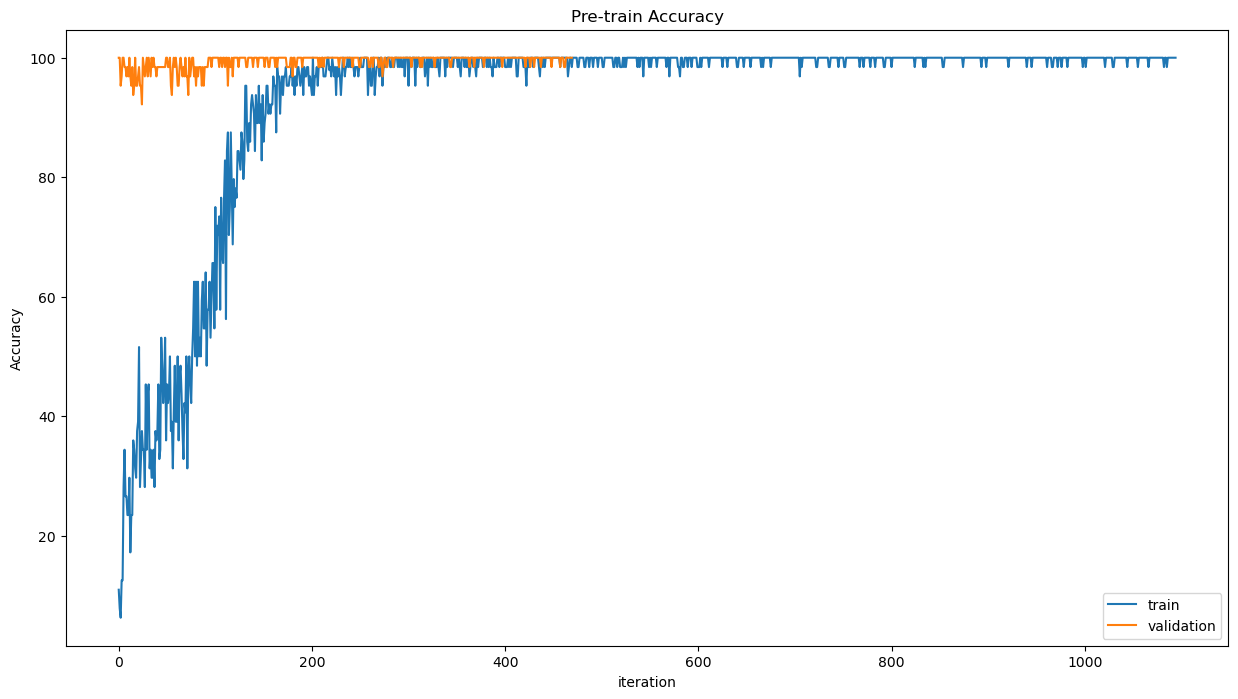

In [2]:
import matplotlib.pyplot as plt

train_record = record[record['type'] == 'train']
val_record = record[record['type'] == 'validation']
plt.figure(figsize=(15, 8))
plt.plot(train_record['step'], train_record['accuracy'], label='train')
plt.plot(val_record['step'], val_record['accuracy'], label='validation')
plt.xlabel('iteration')
plt.ylabel('Accuracy')
plt.title('Pre-train Accuracy')
plt.legend(loc='lower right')
plt.show()

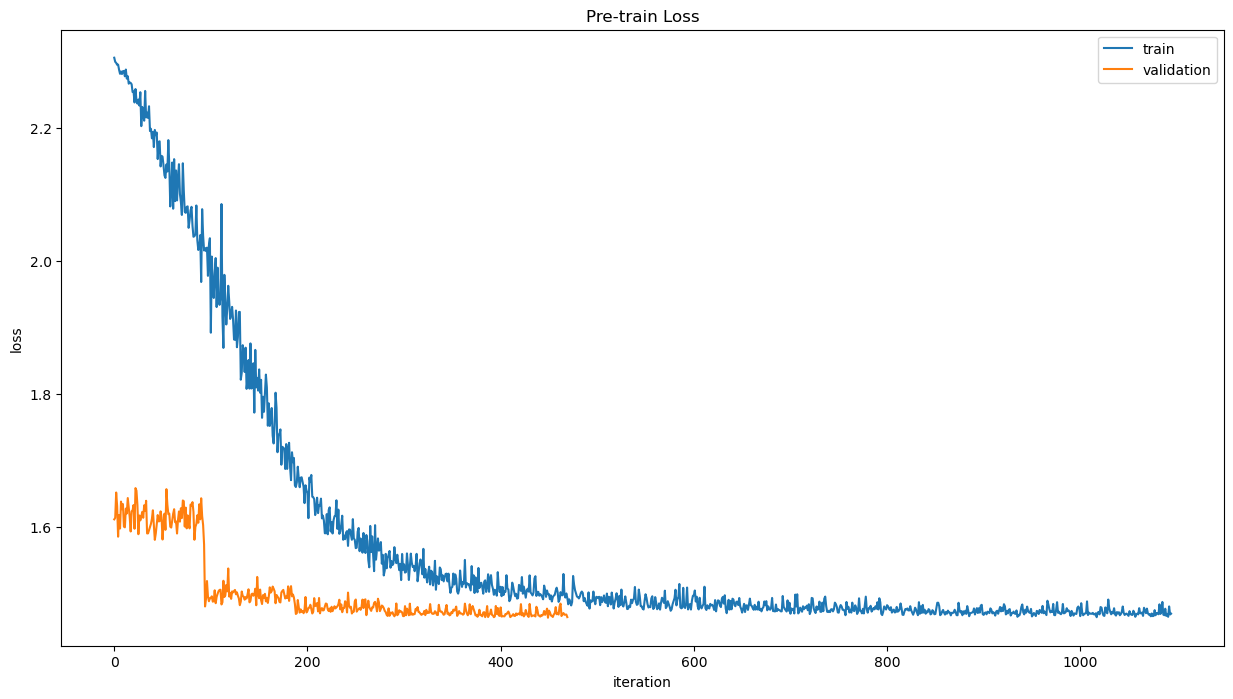

In [3]:
plt.figure(figsize=(15, 8))
plt.plot(train_record['step'], train_record['loss'], label='train')
plt.plot(val_record['step'], val_record['loss'], label='validation')
plt.xlabel('iteration')
plt.ylabel('loss')
plt.title('Pre-train Loss')
plt.legend()
plt.show()

# Test dataset accuracy comparing

In [4]:
from lib.datasets import AudioMINST, load_datapath
from lib.wavUtils import Components, pad_trunc, time_shift, GuassianNoise
from lib.models import WavClassifier
import torch 
import torch.nn as nn
import torchaudio.transforms as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm

accu_record = pd.DataFrame(columns=['dataset', 'algorithm', 'tta-operation', 'corruption', 'accuracy'])

def inference(model: nn.Module, loader: DataLoader, device: str) -> float:
    test_accu = 0.
    test_size = 0.
    test_iter = iter(loader)
    model.eval()
    for iteration in tqdm(range(len(test_loader))):
        inputs, labels = next(test_iter)
        inputs, labels = inputs.cuda(), labels.cuda()
        outputs = model(inputs)
        _, preds = torch.max(outputs, dim=1)
        test_accu += (preds == labels).sum().cpu().item()
        test_size += labels.shape[0]
    return test_accu / test_size * 100.

sample_rate = 48000
data_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    # time_shift(shift_limit=.1),
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=40),
    transforms.AmplitudeToDB(top_db=80),
    # transforms.FrequencyMasking(freq_mask_param=.1),
    # transforms.TimeMasking(time_mask_param=.1)
])
test_data_root_path = '/root/data/AudioMNIST/data'
test_datapathes = load_datapath(root_path=test_data_root_path, filter_fn=lambda x: x['accent']!= 'German')
test_dataset = AudioMINST(data_paths=test_datapathes, include_rate=False, data_trainsforms=data_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = WavClassifier(class_num=10, l1_in_features=64, c1_in_channels=1).to(device=device)
model.load_state_dict(torch.load('result/pre_train/cnn_audio-mnist.pt'))
original_test_accuracy = inference(model=model, loader=test_loader, device=device)
print(f'original test data size: {len(test_dataset)}, original test accuracy: {original_test_accuracy:.2f}')
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'N/A', 'N/A', original_test_accuracy]

100%|██████████| 157/157 [02:24<00:00,  1.08it/s]

original test data size: 10000, original test accuracy: 96.14


In [5]:
data_transforms = Components(transforms=[
    pad_trunc(max_ms=1000, sample_rate=sample_rate),
    GuassianNoise(noise_level=.025),
    transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=1024, n_mels=40),
    transforms.AmplitudeToDB(top_db=80)
])
test_datapathes = load_datapath(root_path=test_data_root_path, filter_fn=lambda x: x['accent'] != 'German')
test_dataset = AudioMINST(data_paths=test_datapathes, include_rate=False, data_trainsforms=data_transforms)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False, drop_last=False)

corrupted_test_accuracy = inference(model=model, loader=test_loader, device=device)
print(f'corrupted test data size: {len(test_dataset)}, corrupted test accuracy: {corrupted_test_accuracy:.2f}')
accu_record.loc[len(accu_record)] = ['Audio MNIST', 'cnn', 'N/A', 'Guassian Noise', corrupted_test_accuracy]

100%|██████████| 157/157 [02:36<00:00,  1.00it/s]

corrupted test data size: 10000, corrupted test accuracy: 13.29


In [6]:
accu_record

,dataset,algorithm,tta-operation,corruption,accuracy
0,Audio MNIST,cnn,N/A,N/A,96.14
1,Audio MNIST,cnn,N/A,Guassian Noise,13.29
